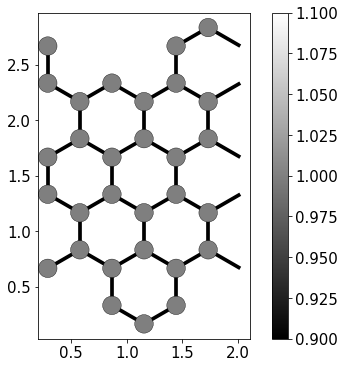

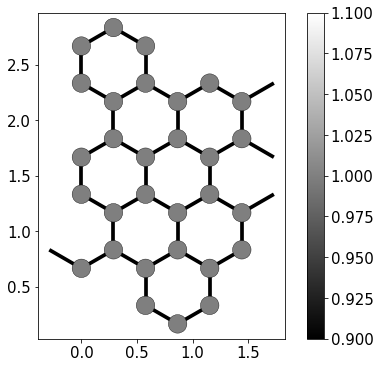

In [143]:
%run notebook_setup.ipy
from helper import *
N=12
L=6
Z7 = make_cove_edged_graphene(N=N,L=L)
cove_ribbon = finite_to_1D(Z7,get_length(L),trans_sym_direction='x')

sites = list(Z7.sites())
pos = [site.pos for site in sites]
pos = translate(pos,0,N,L)
cove_lattice = kwant.lattice.general([[get_length(L),0],[0,get_width(N)]],pos)
cove_ribbon = kwant.Builder(kwant.TranslationalSymmetry(cove_lattice.prim_vecs[0]))
cove_ribbon[cove_lattice.shape((lambda pos: 0 <= pos[1] < get_width(N)),(0,0))]=1
cove_ribbon[cove_lattice.neighbors()] = -1
fig = kwant.plot(cove_ribbon,site_color=family_color,site_lw=0.01);

pos[:,0] = get_length(L) -1*pos[:,0]
pos = translate(pos,np.sqrt(3)/6,N,L)

N4_lattice = kwant.lattice.general([[get_length(L),0],[0,get_width(N)]],pos)
N4 = kwant.Builder(kwant.TranslationalSymmetry(N4_lattice.prim_vecs[0]))
N4[N4_lattice.shape((lambda pos: 0 <= pos[1] < get_width(N)),(0,0))]=1
N4[N4_lattice.neighbors()] = -1
fig = kwant.plot(N4,site_color=family_color,site_lw=0.01);

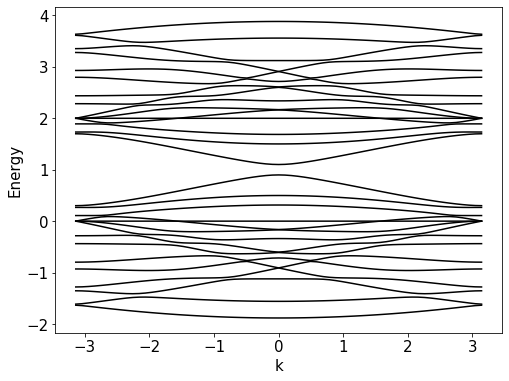


+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                                               |
|       starting at 2019-06-18 21:22:47,165                            |
|       running Z2Pack version 2.1.1                                   |
|                                                                      |
|       init_result: None                                              |
|       iterator:    range(8, 27, 2)                                   |
|       line:        <function <lambda> at 0x7fe30cda0c80>             |
|       load:        False                                             |
|       load_quiet:  True                                              |
|       pos_tol:     0.01                                              |
|       save_file:   None                         

In [142]:
wcc_N={}
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
#cove_ribbon = cove_ribbon.finalized()
kwant.plotter.bands(cove_ribbon)
act_pos = np.array([cove_ribbon.pos(i) for i in range(len(sites))])
a1,a2 = [cove_lattice.prim_vecs[0][0],get_width(N=N)]
red_pos = np.zeros(np.shape(act_pos))
red_pos[:,0] = act_pos[:,0]/a1
red_pos[:,1] = act_pos[:,1]/a2


ham_k=zak_bands_z2(cove_ribbon,momenta=1001,dim=2)
z2_system = z2pack.hm.System(ham_k,dim=2,pos=red_pos,
                                     convention=2)
result = z2pack.line.run(system=z2_system, 
                            line=lambda t1: [t1,0])#,#,n/(N+1)])#,
                            #pos_tol=1e-3,iterator=range(200,500,2));

print("Polarization:",result.pol)

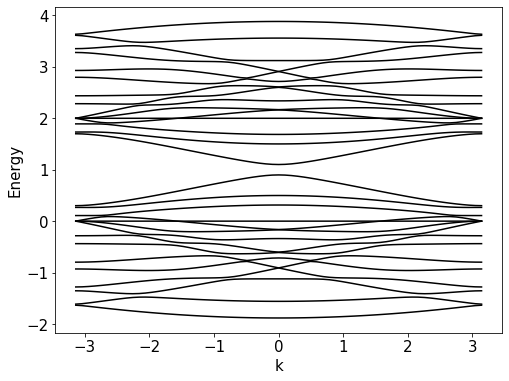


+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                                               |
|       starting at 2019-06-18 21:22:24,953                            |
|       running Z2Pack version 2.1.1                                   |
|                                                                      |
|       init_result: None                                              |
|       iterator:    range(8, 27, 2)                                   |
|       line:        <function <lambda> at 0x7fe30c8ae378>             |
|       load:        False                                             |
|       load_quiet:  True                                              |
|       pos_tol:     0.01                                              |
|       save_file:   None                         

In [140]:
wcc_N={}
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
#cove_ribbon = cove_ribbon.finalized()
#N4 = N4.finalized()
kwant.plotter.bands(N4)
act_pos = np.array([N4.pos(i) for i in range(len(sites))])
a1,a2 = [N4_lattice.prim_vecs[0][0],get_width(N=N)]
red_pos = np.zeros(np.shape(act_pos))
red_pos[:,0] = act_pos[:,0]/a1
red_pos[:,1] = act_pos[:,1]/a2


ham_k=zak_bands_z2(N4,momenta=1001,dim=2)
z2_system = z2pack.hm.System(ham_k,dim=2,pos=red_pos,
                                     convention=2)
result = z2pack.line.run(system=z2_system, 
                            line=lambda t1: [t1,0])#,#,n/(N+1)])#,
                            #pos_tol=1e-3,iterator=range(200,500,2));

print("Polarization:",result.pol)

In [134]:
def make_junciton(syst1,syst2,lx1,lx2,ly):
    lx = lx1 + lx2
    nx = 5 
    nx1 = nx 
    nx2 = nx
    pos_all0 = []
    #pos1 =  [[site.pos[0],site.pos[1]] for site in syst1.sites()]
    #pos2 =  [[site.pos[0],site.pos[1]] for site in syst2.sites()]
    for i in range(nx1):
        pos1 =  [[site.pos[0] + i*lx1,site.pos[1]] for site in syst1.sites()]
        pos_all0 += pos1
    for i in range(nx2): 
        pos2 =  [[site.pos[0] + nx1*lx1 + i*lx2+np.sqrt(3)/6,site.pos[1]] for site in syst2.sites()]
        pos_all0 += pos2
    #pos_all = pos_all0
    pos_all = []
    for item in pos_all0:
        if item not in pos_all: 
            pos_all.append(item)
        #print(item)

    min_y = np.min(np.array(pos_all)[:,1])
    lat = kwant.lattice.general([[nx*lx,0],[0,2*ly]],pos_all,norbs=1)
    #syst = kwant.Builder(kwant.TranslationalSymmetry([lx,0]))
    syst = kwant.Builder()
    syst[lat.shape((lambda pos: 0<pos[0]< nx*lx and min_y<=pos[1]<ly),(0,0))] = 0 
    syst[lat.neighbors()] = -1 
    print(len(pos1),len(pos2),len(pos_all))
    return syst 

def plot_wf(syst,i_start,i_end,ham):
    """Plot the wave function mapping on system with Hamiltonian 
    "ham" in a PyWidget starting from band index i_start and 
    ending at i_end"""
    eig_val,eig_vec = la.eigh(ham)
    def plot_band(i=0): 
        print("Plotting wave function with index",i)
        print("Energy of the corresponding mode",eig_val[i], "x t")
        fig = kwant.plotter.map(syst,abs(eig_vec[:,i])**2,oversampling=3,fig_size=(16,10))
        
        #fig.savefig('figures/%s.jpg'%i,dpi=400,quality=100,transparent=True)
    
    interact(plot_band,i=(i_start,i_end))

In [144]:
def check_junction(syst1,syst2,lx1,lx2,ly=14):
    syst = make_junciton(syst1,syst2,lx1,lx2,ly)
    #syst.eradicate_dangling()
    kwant.plot(syst,site_color='black');
    
    nbands = len(syst.sites())
    n1 = int(nbands/2 -5)
    n2 = int(nbands/2 +5)
    print('Number of bands in junction is {}'.format(nbands))
    
    syst = syst.finalized()
    ham = syst.hamiltonian_submatrix() 
    fig = plot_wf(syst,n1,n2,ham)

30 30 300


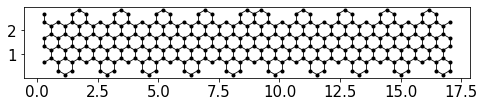

Number of bands in junction is 296


interactive(children=(IntSlider(value=143, description='i', max=153, min=143), Output()), _dom_classes=('widge…

In [145]:
check_junction(cove_ribbon,N4,lx1=get_length(6),lx2=get_length(6),ly=16)

In [120]:
syst = make_junciton(cove_ribbon,N4,lx1=get_length(6),lx2=get_length(6),ly=16)

30 30 180


In [34]:
for sites in syst.sites():
    print(sites.pos)

[0.8659254037844386 0.3333333333333333]
[0.8659254037844386 0.6666666666666666]
[1.7319508075688772 0.8333333333333334]
[1.4432756729740643 1.3333333333333333]
[0.2885751345948129 0.6666666666666666]
[1.7319508075688772 1.1666666666666667]
[0.8659254037844386 1.3333333333333333]
[0.5772502691896257 1.1666666666666667]
[1.4432756729740643 0.6666666666666666]
[0.5772502691896257 0.8333333333333334]
[1.7319508075688772 1.8333333333333335]
[0.8659254037844386 1.6666666666666665]
[0.5772502691896257 1.8333333333333335]
[1.4432756729740643 1.6666666666666665]
[1.4432756729740643 0.3333333333333333]
[0.8659254037844386 2.3333333333333335]
[1.7319508075688772 2.8333333333333335]
[0.5772502691896257 2.1666666666666665]
[0.2885751345948129 1.3333333333333333]
[1.1546005383792515 2.1666666666666665]
[1.1546005383792515 0.8333333333333334]
[1.1546005383792515 1.8333333333333335]
[1.4432756729740643 2.3333333333333335]
[1.7319508075688772 2.1666666666666665]
[1.1546005383792515 0.16666666666666666]

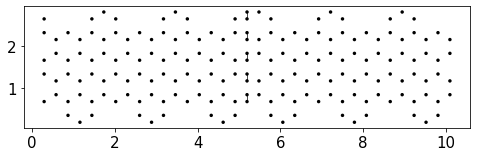

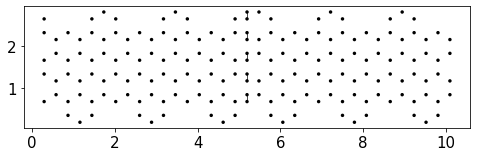

In [121]:
kwant.plot(syst)

In [71]:
a = [[1,2]]
b = [[1,2],[2,3]]
list(set(a)|set(b))

TypeError: unhashable type: 'list'

In [78]:
a = [[1,2],[3,4]]

In [81]:
[1,2] in a

True